# Data Scraping

In [16]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
from math import ceil
import string 

In [17]:
BASE_URL = "https://www.gutenberg.org"
PARSER_NAME = 'lxml'

Code which creates a Pandas dataframe where:
  - Each dictionary within the list contains the information; more specifically, the title, author, and link to the HTML version of the books are stored in each dictionary.
  - The order of these dictionaries within the list is the same order as their 'ranking' on the Gutenberg website.
  - Books which do not have an HTML version (e.g. math textbooks or picture books which contain large amounts of content which isn't plain text) are ignored.
  - The created dictionary will contain exactly `num_2_get` books.

In [40]:
def process_booklinks(bl_element, book_id, num_2_take):
  # Create urls for corresponding books:
  book_urls = [BASE_URL + "/ebooks/" + str(id) for id in book_id]
  # Get soups for each link:
  soup_list = [BeautifulSoup(requests.get(url).text, PARSER_NAME) for url in book_urls]
  # Find URL extensions associated with "HTML (Original)" text links on page:
  html_ext = [s.find('a', text="Read this book online: HTML (original)") for s in soup_list]
  # Regex to remove special characters at end of title string:
  specchar_regex = re.compile('(\\n)|(\\r)|(\\r\\n)')
  # Get lists of Authors, Titles, and links for books with HTML versions available:
  authors, titles, urls = [], [], []
  # Iterate over each book's unique description page:
  for i, ext in enumerate(html_ext):
    # Only add book if it has an HTML version of the book is available AND
    # if we still haven't taken num_2_take books:
    if ext is not None and len(authors) < num_2_take:
      # Get title from list of booklinks:
      title_i = bl_element[i].find(class_="title").contents[0]
      # Some titles have /r character at end - remove them if so:
      #title_i = title_i[:-2] if title_i[-2:] == '\r' else title_i
      title_i = re.sub(specchar_regex, '', title_i)
      titles.append(title_i)
      # Get author from list of booklinks - need to check if book has a non-empty
      # author tag:
      author_i = bl_element[i].find(class_="subtitle")
      author_i = author_i.contents[0] if author_i is not None else "Anonymous"
      authors.append(author_i)
      # Get URL of HTML version of text:
      urls.append(BASE_URL + str(ext['href']))
  # Return these lists:
  return (authors, titles, urls)

def get_book_info(num_2_get):
  # Generate URLs of webpages to visit by appending extension to end of base directory:
  start_url = BASE_URL + "/ebooks/search/?sort_order=downloads"
  # Initialise loop variables:
  current_url = start_url
  num_books = 0 
  num_books_checked = 0
  # Initialise lists to store author, title, and url information for each book:
  author_list, title_list, url_list = [], [], []
  # Get the number of books we've specified:
  while num_books < num_2_get:
    # Get soup of current URL:
    soup = BeautifulSoup(requests.get(current_url).text, PARSER_NAME)
    # Get booklink elements off this page:
    current_el = [x for x in soup.find_all(class_='booklink')]
    # Determine the maximum number of books we need to take from this page:
    num_2_take = min(len(current_el), num_2_get - num_books)
    # Get book 'id' of each book on page:
    current_id = [x.a['href'].split('/')[-1] for x in current_el]
    # Get the Title, Author and URLs for each book which has an HTML version:
    (authors_i, titles_i, urls_i) = process_booklinks(current_el, current_id, num_2_take)
    # Append to our 'grand' lists:
    author_list += authors_i
    title_list += titles_i
    url_list += urls_i
    # Update how many books we've collected and checked from this page:
    num_books += len(authors_i)
    num_books_checked += len(current_id)
    # Update our current_url:
    current_url = start_url + f"&start_index={num_books_checked+1}"
  # Convert these lists into a Pandas dataframe:
  book_df = pd.DataFrame.from_dict({'title': title_list,
                                    'author': author_list,
                                    'url': url_list})
  return book_df

In [41]:
num_2_get = 100
book_df = get_book_info(num_2_get)

Now that we have a dictionary which contains links to the HTML version of each book we want to scrape, let's now actually scrape the text of each book:

In [20]:
def get_text(book_df):
  # Create regex to 'clean' text we'll scrape:
  punct_regex = re.escape(string.punctuation)
  char_regex = re.compile('([^ [a-zA-Z0-9]])&([^{}])'.format(punct_regex))
  specchar_regex = re.compile('(\\n)|(\\r)|(\\r\\n)')
  tag_regex = re.compile('(\<\d\>)|(\</\d\>)')
  space_regex = re.compile(' +')
  # Initialise list to store text:
  text_list = []
  # Iterate over urls in dataframe:
  for url in book_df['url']:
    # Get soup of page:
    soup = BeautifulSoup(requests.get(url).text.encode("ascii", 'ignore'), PARSER_NAME)
    # Initialise string to contain text:
    text_i = ''
    # Iterate over paragraphs on page and add to text:
    all_paras = soup.find_all('p')
    for p in all_paras:
      # Remove unwanted characters:
      text_chunk = re.sub(char_regex, ' ', p.get_text())
      text_chunk = re.sub(specchar_regex, ' ', text_chunk)
      text_chunk = re.sub(tag_regex, ' ', text_chunk)
      # Replace multiple spaces with single spaces:
      text_chunk = re.sub(space_regex, ' ', text_chunk)
      if len(text_chunk) > 0:
        text_chunk = ' '+text_chunk if text_chunk[0]!=' ' else text_chunk
        text_i += text_chunk
    # Append i'th text to list:
    text_list.append(text_i)
  # Add text list as new column to dataframe:
  book_df['text'] = text_list
  return book_df

text_df = get_text(book_df)

To check that this has worked, let's save a specified book to a text file so that we may manually check it:

In [6]:
idx_to_check = 25
with open('check.txt', 'w') as f:
    f.write(text_df.loc[idx_to_check,'text'])

Save to CSV:

In [21]:
text_df.to_csv('text.csv')

# Use BERT Network to Compute Text Complexity


Install HuggingFace `transformers` package:

In [6]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 636 kB 47.6 MB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 50.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Package imports:

In [24]:
# PyTorch and Numpy imports:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

# HuggingFace imports:
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Misc libraries:
import os

Set device:

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Specify random seed:

In [9]:
RANDOM_SEED = 32
torch.manual_seed(RANDOM_SEED)

Download fine-tuned BERT model weights - MUST UPLOAD KAGGLE API KEY FOR THIS TO WORK:

In [10]:
if not os.path.exists('/root/.kaggle/'):
    os.makedirs('/root/.kaggle/')
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d matthewabilton/finetuned-bert-readability
!unzip finetuned-bert-readability.zip

 93% 218M/236M [00:02<00:00, 85.2MB/s]
100% 236M/236M [00:02<00:00, 87.5MB/s]
Archive:  finetuned-bert-readability.zip
  inflating: best_model/config.json  
  inflating: best_model/pytorch_model.bin  
  inflating: tokenizer/special_tokens_map.json  
  inflating: tokenizer/tokenizer_config.json  
  inflating: tokenizer/vocab.txt     


Specify maximum text chunk length and load tokenizer (both treated as global variables):

In [11]:
MAX_LEN = 250
load_dir = "./tokenizer"
TOKENIZER = DistilBertTokenizer.from_pretrained(load_dir)

Define custom dataset object to hold text chunks from Gutenberg books:

In [12]:
class GutenbergData(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item_i = self.dataset[idx]
        dict_i = {"id": item_i[0],
                  "mask": item_i[1],
                  "text_id": item_i[2]}
        return dict_i

Code to pre-process text data into a PyTorch dataset object:

In [48]:
# Processes each chunk of tokenized text so it can be 'understood' by BERT:
def process_chunks(id_chunk, mask_chunk, max_len, start_id=101, end_id=102):
  # Add start and stop IDs:
  id_chunk = torch.cat([torch.tensor([start_id]), id_chunk, torch.tensor([end_id])])
  mask_chunk = torch.cat([torch.ones(1), mask_chunk, torch.ones(1)])
  # Pad chunks if required:
  if len(id_chunk) < max_len:
    pad_len = max_len - len(id_chunk)
    id_chunk = torch.cat([id_chunk, torch.zeros(pad_len)])
    mask_chunk = torch.cat([mask_chunk, torch.zeros(pad_len)])
  return (id_chunk, mask_chunk)

def create_dataset(text_df, tokenizer, max_len):
  X_id, X_mask, text_id = [], [], []
  for i, text in enumerate(text_df["text"]):
    id_list, mask_list = [], []
    tokens = tokenizer.encode_plus(text, add_special_tokens=False, return_tensors='pt')
    if (i+1)%10==0 and i>0:
      print(f'Finished tokenizing {i+1}/{text_df.shape[0]} texts.')
    ids = tokens["input_ids"][0].split(max_len-2)
    masks = tokens["attention_mask"][0].split(max_len-2)
    for id_chunk, mask_chunk in zip(ids, masks):
      id_chunk, mask_chunk = process_chunks(id_chunk, mask_chunk, max_len)
      id_list.append(id_chunk), mask_list.append(mask_chunk)
    X_id.append(torch.stack(id_list, dim=0))
    X_mask.append(torch.stack(mask_list, dim=0))
    text_id.append(i*torch.ones(len(ids)))
  X_id = torch.cat(X_id, axis=0)
  X_mask = torch.cat(X_mask, axis=0)
  text_id = torch.cat(text_id, axis=0)
  # Ensure tensors are all integer values:
  X_id = torch.as_tensor(X_id, dtype=torch.int64)
  X_mask = torch.as_tensor(X_mask, dtype=torch.int64)
  text_id = torch.as_tensor(text_id, dtype=torch.int64).reshape((X_id.shape[0], 1))
  # Place in dataset object:
  dataset = TensorDataset(X_id, X_mask, text_id)
  dataset = GutenbergData(dataset)
  return dataset

Create dataset object and place into dataloader (takes around five to six minutes to complete):

In [49]:
text_ds = create_dataset(text_df, TOKENIZER, MAX_LEN)
torch.save(text_ds, 'gutenberg_input.pth')
batch_size = 32
text_dl = DataLoader(text_ds,
                     batch_size=batch_size,
                     shuffle=False)

Finished tokenizing 10/100 texts.
Finished tokenizing 20/100 texts.
Finished tokenizing 30/100 texts.
Finished tokenizing 40/100 texts.
Finished tokenizing 50/100 texts.
Finished tokenizing 60/100 texts.
Finished tokenizing 70/100 texts.
Finished tokenizing 80/100 texts.
Finished tokenizing 90/100 texts.
Finished tokenizing 100/100 texts.


Define BERT model class:

In [56]:
class BertModel():
  def __init__(self, load_dir):
    self.model = DistilBertForSequenceClassification.from_pretrained(load_dir)
    # Move model to device:
    self.model.to(device)
  
  def predict(self, id, att_mask, text_id):
    with torch.no_grad():
      if self.model.training:
        self.model.eval()
      # Move inputs to device:
      id, att_mask = id.to(device), att_mask.to(device)
      # Make prediction with BERT model:
      logits = self.model(input_ids=id, attention_mask=att_mask)["logits"]
      # Convert output to NumPy array:
      logits = logits.cpu().numpy()
      # Append text_id to each prediction:
      pred = np.concatenate((text_id, logits), axis=1)
      return pred

Create BERT model:

In [57]:
load_dir = "./best_model"
bert_model = BertModel(load_dir)

Use Bert model to predict the difficulty of the text chunks in the dataloader (takes approximately 20 minutes on a GPU):

In [64]:
pred_array = np.array([])
for i, d in enumerate(text_dl):
  if (i+1)%100==0:
    print(f"Batch {i+1} out of {len(text_dl)}.")
  pred_i = bert_model.predict(d["id"], d["mask"], d["text_id"])
  pred_array = np.vstack((pred_array, pred_i)) if pred_array.size>0 else pred_i
# Place predicted values in dataframe:
pred_df = pd.DataFrame(pred_array, columns=["text_id", "pred"])
# Make sure text_id's are integers:
pred_df["text_id"] = pred_df["text_id"].apply(lambda x: int(x))
# Save dataframe:
pred_df.to_csv('gutenberg_pred.csv')

Batch 100 out of 1942.
Batch 200 out of 1942.
Batch 300 out of 1942.
Batch 400 out of 1942.
Batch 500 out of 1942.
Batch 600 out of 1942.
Batch 700 out of 1942.
Batch 800 out of 1942.
Batch 900 out of 1942.
Batch 1000 out of 1942.
Batch 1100 out of 1942.
Batch 1200 out of 1942.
Batch 1300 out of 1942.
Batch 1400 out of 1942.
Batch 1500 out of 1942.
Batch 1600 out of 1942.
Batch 1700 out of 1942.
Batch 1800 out of 1942.
Batch 1900 out of 1942.


For each book, compute the average and standard deviation of the difficulty; store these values in a dataframe alongside the text's id and name:

In [32]:
id_list, avg_list, std_list = [], [], []
for id in pred_df['text_id'].unique():
  id_list.append(id)
  pred_i = pred_df.loc[pred_df["text_id"]==id, 'pred']
  avg_list.append(np.nanmean(pred_i))
  std_list.append(np.nanstd(pred_i))
avg_array = np.array((id_list, avg_list, std_list)).T
avg_df = pd.DataFrame(avg_array, columns=['text_id','avg','std'])

For convenience, replace the `text_id` column with the Title and Author of the book that `text_id` corresponds to:

In [33]:
# Add title and author to avg_df corresponding to each text_id:
avg_df[['title', 'author']] = text_df.loc[avg_df['text_id'], ['title', 'author']]
# Drop now unneeded text_id column:
avg_df.drop(columns='text_id')
# Rearrange order of columns:
avg_df = avg_df[['title', 'author', 'avg', 'std']]
# Save dataframe to csv:
avg_df.to_csv("gutenberg_avg.csv")

Let's see what `avg_df` looks like:

In [46]:
avg_df

,title,author,avg,std
0,Pride and Prejudice,Jane Austen,-1.708225,0.492205
1,Alice's Adventures in Wonderland,Lewis Carroll,-0.449484,0.413632
2,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,-1.972498,0.425252
3,The Adventures of Sherlock Holmes,Arthur Conan Doyle,-1.198604,0.470576
4,"Moby Dick; Or, The Whale",Herman Melville,-2.130047,0.407357
...,...,...,...,...
95,Pygmalion,Bernard Shaw,-1.734564,0.396406
96,Candide,Voltaire,-2.026641,0.425517
97,The Life and Adventures of Robinson Crusoe,Daniel Defoe,-1.667257,0.467325
98,Three Men in a Boat (To Say Nothing of the Dog),Jerome K. Jerome,-1.136298,0.564644


# Initial Visualisation of Results

Let's first ensure that our installation of Plotly Express is up-to-date on our machine:

In [ ]:
!pip install --upgrade plotly

Next, our imports:

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

If we need to re-import our averaged and raw data (which we might need to do if we've reset our computing instance), let's do that now:

In [47]:
pred_df = pd.read_csv('gutenberg_pred.csv')
avg_df = pd.read_csv('gutenberg_avg.csv')

Let's now plot the standard deviation vs mean of text difficulty:

In [2]:
import plotly.express as px
avg_df = pd.read_csv('gutenberg_avg.csv')
px.scatter(avg_df, x='std', y='avg', hover_data=['title', 'author'])

*Notes from the Underground* by Dostoevsky appears to have a high variability in text difficulty - let's plot out its difficulty distribution:

In [85]:
# Function to plot difficulty distribution of a specified book:
def plot_difficulty_dist(book_title, avg_df, pred_df):
  book_idx = avg_df[avg_df['title'].str.contains(book_title, case=False)].index[0]
  book_mask = pred_df["text_id"] == book_idx
  book_pred = pred_df.loc[book_mask, 'pred']
  fig, ax1 = plt.subplots()
  plt.xlabel('Difficulty')
  sns.kdeplot(data=book_pred, ax=ax1, color='r', fill=True)
  ax2 = ax1.twinx()
  sns.histplot(data=book_pred, ax=ax2, binwidth=0.1)
  sns.set_style("darkgrid")

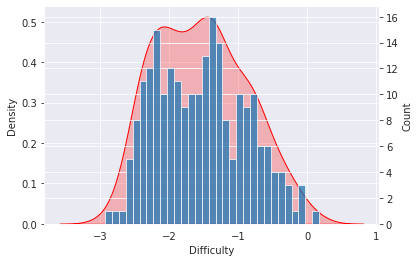

In [77]:
# Let's plot out the difficulty distribution of 'Notes from the Underground':
book_title = 'Notes from the Underground'
plot_difficulty_dist(book_title, avg_df, pred_df)

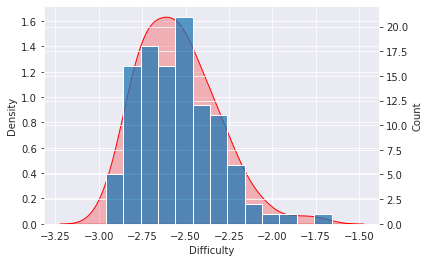

In [86]:
# Let's plot out the difficulty distribution of 'An Index from the Divine Comedy':
book_title = 'Common Sense'
plot_difficulty_dist(book_title, avg_df, pred_df)